## Using Colab GPU for Training


In [1]:
!rm -rf NLP_Colab
!git clone https://github.com/sumkh/NLP_Colab.git

Cloning into 'NLP_Colab'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 81 (delta 44), reused 30 (delta 12), pack-reused 0
Unpacking objects: 100% (81/81), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [7]:
!pip install transformers -q

     |████████████████████████████████| 501kB 5.0MB/s 
     |████████████████████████████████| 1.0MB 16.2MB/s 
     |████████████████████████████████| 870kB 33.4MB/s 
     |████████████████████████████████| 3.7MB 45.3MB/s 


# Training and Fine-Tuning BERT

## Loading the Training and Validation Data

In [5]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("NLP_Colab/Multi.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 5 random rows from the data.
df.sample(5)

Number of training sentences: 6,697



,mydata,Aspects,Sentiment,Emotion,sales,earnings,op_costs,products_services,organic_expansion,acquisitions,competition,op_risks,debt,not_applicable,NIL,Slabel_f,Elabel_f
4005,"So, obviously, good quarter this quarter",sales,Positive,Confident,1,0,0,0,0,0,0,0,0,0,0,2,0
3404,"We don't need to chase growth here, we can be ...",sales,Positive,Confident,1,0,0,0,0,0,0,0,0,0,0,2,0
186,Note that these incentives are now being faced...,products_services,Positive,Confident,0,0,0,1,0,0,0,0,0,0,0,2,0
5084,We're seeing the U.S,NIL,Neutral,NIL,0,0,0,0,0,0,0,0,0,0,1,1,2
199,"Because safety is so critical, the automotive ...",products_services,Negative,NIL,0,0,0,1,0,0,0,0,0,0,0,0,2


## BERT Tokenizer

In [66]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


03/24/2020 08:50:48 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [9]:
# Categories of Aspects
label_list = ["sales","earnings","op_costs","products_services","organic_expansion","acquisitions","competition","op_risks","debt","not_applicable","NIL"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}
num_labels = len(label_list) # 11

# Categories of Sentiment
Slabel_list = ["Negative","Neutral","Positive",] # Follow order in Slabel_f
Slabel2id = {label: i for i, label in enumerate(Slabel_list)}
Sid2label = {i: label for i, label in enumerate(Slabel_list)}
s_num_labels = len(Slabel_list) # 3

# Categories of Emotion
Elabel_list = ["Confident","Dodgy","NIL","Uncertain"] # Follow order in Elabel_f
Elabel2id = {label: i for i, label in enumerate(Elabel_list)}
Eid2label = {i: label for i, label in enumerate(Elabel_list)}
e_num_labels = len(Elabel_list) # 4

id2label

{0: 'sales',
 1: 'earnings',
 2: 'op_costs',
 3: 'products_services',
 4: 'organic_expansion',
 5: 'acquisitions',
 6: 'competition',
 7: 'op_risks',
 8: 'debt',
 9: 'not_applicable',
 10: 'NIL'}

In [0]:
Sid2label

{0: 'Negative', 1: 'Neutral', 2: 'Positive'}

In [0]:
Eid2label

{0: 'Confident', 1: 'Dodgy', 2: 'NIL', 3: 'Uncertain'}

In [10]:
# Set labels for Aspect
label_f = df[["sales","earnings","op_costs","products_services","organic_expansion","acquisitions","competition","op_risks","debt","not_applicable","NIL"]]
label_f = label_f.values.tolist()
print(label_list)
print("Number of Labels: " + str(num_labels))
label_f[0:3]

['sales', 'earnings', 'op_costs', 'products_services', 'organic_expansion', 'acquisitions', 'competition', 'op_risks', 'debt', 'not_applicable', 'NIL']
Number of Labels: 11


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]

In [11]:
# Set labels for Sentiment
s_label_f = df[["Slabel_f"]]
s_label_f = s_label_f.values.tolist()

# Set labels for Emotion
e_label_f = df[["Elabel_f"]]
e_label_f = e_label_f.values.tolist()

# Convert text to numpy arrays
text = df.iloc[:,0]
text = text.values.tolist()
text[0:3]

['Yeah',
 'One is more for the data center',
 'Premiere Pro is the worlds leading video production solution, and continues to grow its footprint across every video segment']

In [67]:
import numpy as np
import argparse
import collections
import logging
import json
import re
import math

import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from transformers import BertTokenizer
from transformers import BertModel

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

class InputExample(object):

    def __init__(self, unique_id, text_a, text_b, labels, s_labels, e_labels):
        self.unique_id = unique_id
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels
        self.s_labels = s_labels
        self.e_labels = e_labels

# Get the lists of sentences and their labels.
input_file = zip(text, label_f, s_label_f, e_label_f)

corpus = []
unique_id = 0
for txt, lab_f, s_lab_f, e_lab_f in input_file:
  line = txt.strip()
  text_a = None
  text_b = None
  m = re.match(r"^(.*) \|\|\| (.*)$", line)
  if m is None:
    text_a = line
  else:
    text_a = m.group(1)
    text_b = m.group(2)
  
  label = [np.float(x) for x in lab_f]
  
  corpus.append(InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b, 
                             labels = label, s_labels = s_lab_f, e_labels = e_lab_f))
  unique_id += 1

MAX_LEN = int(math.ceil(max([len(keys.split()) for keys in text])/10)*10)
print('Max sentence length: ' + str(MAX_LEN))

Max sentence length: 160


In [68]:
# Set the maximum sequence length.
# In the original paper, the authors used a length of 512.
seq_length = MAX_LEN 
# type=int
# The maximum total input sequence length after WordPiece tokenization. 
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.

def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, unique_id, labels, s_labels, e_labels, tokens, input_ids, input_mask, input_type_ids):
        self.unique_id = unique_id
        self.labels = labels
        self.s_labels = s_labels
        self.e_labels = e_labels
        self.tokens = tokens
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.input_type_ids = input_type_ids

# Reference: corpus.(unique_id, text_a, text_b, labels, s_labels, e_labels)
features = []
for (txt_index, sent_pair) in enumerate(corpus):
    tokens_a = tokenizer.tokenize(sent_pair.text_a)

    tokens_b = None
    if sent_pair.text_b:
        tokens_b = tokenizer.tokenize(sent_pair.text_b)

    if tokens_b:
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, seq_length - 3)
    else:
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > seq_length - 2:
            tokens_a = tokens_a[0:(seq_length - 2)]

    tokens = []
    input_type_ids = []
    tokens.append("[CLS]")
    input_type_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        input_type_ids.append(0)
    tokens.append("[SEP]")
    input_type_ids.append(0)

    if tokens_b:
        for token in tokens_b:
            tokens.append(token)
            input_type_ids.append(1)
        tokens.append("[SEP]")
        input_type_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < seq_length:
        input_ids.append(0)
        input_mask.append(0)
        input_type_ids.append(0)

    assert len(input_ids) == seq_length
    assert len(input_mask) == seq_length
    assert len(input_type_ids) == seq_length

    if txt_index < 5:
        logger.info("******")
        logger.info("unique_id: %s" % (sent_pair.unique_id))
        logger.info("Aspect labels: %s" % (sent_pair.labels))
        logger.info("Sentiment labels: %s" % (sent_pair.s_labels))
        logger.info("Emotion labels: %s" % (sent_pair.e_labels))
        logger.info("tokens: %s" % " ".join([str(x) for x in tokens]))
        logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
        logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
        logger.info(
            "input_type_ids: %s" % " ".join([str(x) for x in input_type_ids]))
        
    features.append(InputFeatures(
                unique_id=sent_pair.unique_id,
                labels=sent_pair.labels,
                s_labels=sent_pair.s_labels,
                e_labels=sent_pair.e_labels,
                tokens=tokens,
                input_ids=input_ids,
                input_mask=input_mask,
                input_type_ids=input_type_ids))
    

03/24/2020 08:51:19 - INFO - __main__ -   ******
03/24/2020 08:51:19 - INFO - __main__ -   unique_id: 0
03/24/2020 08:51:19 - INFO - __main__ -   Aspect labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
03/24/2020 08:51:19 - INFO - __main__ -   Sentiment labels: [1]
03/24/2020 08:51:19 - INFO - __main__ -   Emotion labels: [2]
03/24/2020 08:51:19 - INFO - __main__ -   tokens: [CLS] yeah [SEP]
03/24/2020 08:51:19 - INFO - __main__ -   input_ids: 101 3398 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/24/2020 08:51:19 - INFO - __main__ -   input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Divide up our training set to use 90% for training and 10% for validation.

In [0]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
t_features, v_features = train_test_split(features, random_state=123, test_size=0.1)


## Converting to PyTorch Data Types

Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32. 
# For Colab, recommend batch size of 8

batch_size = 8
local_rank = -1 
#local_rank for distributed training on gpus

# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
unique_id_to_feature = {}
for feature in t_features:
    unique_id_to_feature[feature.unique_id] = feature

if local_rank != -1:
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[local_rank], output_device=local_rank)
elif n_gpu > 1:
    model = torch.nn.DataParallel(model)


# Convert to tensors, need "input_ids & its index", "input_mask" and "input_label"
# For Training set
t_input_ids = torch.tensor([f.input_ids for f in t_features], dtype=torch.long) # Token ids for every sentences in individual list
t_input_ids_index = torch.arange(t_input_ids.size(0), dtype=torch.long) # Index for each sentences in one list
t_input_mask = torch.tensor([f.input_mask for f in t_features], dtype=torch.long)

# Training and Labels for each task
t_input_label = torch.tensor([f.labels for f in t_features], dtype=torch.long)
t_input_s_label = torch.tensor([f.s_labels for f in t_features], dtype=torch.long)
t_input_e_label = torch.tensor([f.e_labels for f in t_features], dtype=torch.long)

train_data = TensorDataset(t_input_ids, t_input_mask, 
                           t_input_label, t_input_s_label, t_input_e_label, 
                           t_input_ids_index)

# Create the DataLoader for our training set.
if local_rank == -1:
    train_sampler = SequentialSampler(train_data)
else:
    train_sampler = DistributedSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) # No of item in dataloader = Total sample / Batch_size


# For Validation set
v_input_ids = torch.tensor([f.input_ids for f in v_features], dtype=torch.long) # Token ids for every sentences in individual list
v_input_ids_index = torch.arange(v_input_ids.size(0), dtype=torch.long) # Index for each sentences in one list
v_input_mask = torch.tensor([f.input_mask for f in v_features], dtype=torch.long)

# Validation and Labels for each task
v_input_label = torch.tensor([f.labels for f in v_features], dtype=torch.long)
v_input_s_label = torch.tensor([f.s_labels for f in v_features], dtype=torch.long)
v_input_e_label = torch.tensor([f.e_labels for f in v_features], dtype=torch.long)

validation_data = TensorDataset(v_input_ids, v_input_mask, 
                                v_input_label, v_input_s_label, v_input_e_label,
                                v_input_ids_index)

# Create the DataLoader for our validation set.
if local_rank == -1:
    validation_sampler = SequentialSampler(validation_data)
else:
    validation_sampler = DistributedSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size) # No of item in dataloader = Total sample / Batch_size


## Defining the Classification Layers

In [0]:
import torch.nn as nn
from transformers.modeling_bert import BertPreTrainedModel, BertModel
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss

class BertForMultitask(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForMultitask, self).__init__(config)
        self.bert = BertModel(config)
        
        self.classifier = nn.Linear(config.hidden_size, out_features=11)
        self.s_classifier = nn.Linear(config.hidden_size, out_features=3)
        self.e_classifier = nn.Linear(config.hidden_size, out_features=4)

        # define dropout layer in __init__
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.init_weights()

    def forward(self, input_ids=None, token_type_ids=None, attention_mask=None, 
                labels=None, s_labels=None, e_labels=None):
        _, pooled_output  = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        
        # apply model dropout to each classifier layer, responseive to eval()
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # apply model dropout to each classifier layer, responseive to eval()
        pooled_output = self.dropout(pooled_output)
        s_logits = self.s_classifier(pooled_output)

        # apply model dropout to each classifier layer, responseive to eval()
        pooled_output = self.dropout(pooled_output)
        e_logits = self.e_classifier(pooled_output)
        
        # When training, provides label and loss will be included into output, 
        # for validation, no label will be entered
        if labels is not None:
          loss_fct = BCEWithLogitsLoss() ## pos_weight=[1,1,1,1,1,1,1,1,1,1,1]
          loss = loss_fct(logits.float(), labels.float())
        
          s_loss_fct = CrossEntropyLoss()
          s_loss = s_loss_fct(s_logits.view(-1, 3), s_labels.view(-1))
          
          e_loss_fct = CrossEntropyLoss()
          e_loss = e_loss_fct(e_logits.view(-1, 4), e_labels.view(-1))
        
          # view function is meant to reshape the tensor. 
          # If there is any situation that you don't know how many rows you 
          # want but are sure of the number of columns (i.e. num_label), 
          # then you can specify this with a -1 so that the logits are reshaped
          # to matrix of 1xNum_label
        
          losses = loss + s_loss + e_loss
          return losses
        
        else: 
          all_logits = logits, s_logits, e_logits
          return all_logits

        outputs = (losses,) + all_logits
        return outputs


    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True


### Loading the Model

In [73]:
from transformers import AdamW, BertConfig

# Load Custom layer for BertForMultitask, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForMultitask.from_pretrained("bert-base-uncased")   

# Tell pytorch to run this model on the GPU.
model.to(device)

03/24/2020 08:51:56 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
03/24/2020 08:51:56 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings"

BertForMultitask(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

### Model's Parameters

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [74]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-8:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 205 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose **8** when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (**We'll use 2e-5**).
- Number of epochs: 2, 3, 4  (**We'll use 4**).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [0]:
from transformers import get_linear_schedule_with_warmup

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs (authors recommend between 2 and 4)
epochs = 20

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

Define a helper function for calculating accuracy.

In [0]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Reference Compute Softmax function using numpy:
# https://gist.github.com/alceufc/f3fd0cd7d9efb120195c
def np_softmax(x):
    scoreMatExp = np.exp(np.asarray(x))
    return scoreMatExp / scoreMatExp.sum(0)

def flat_accuracy(preds, labels):
    preds = np_softmax(preds)
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def accuracy_thresh(y_pred, y_true, thresh=0.5, sigmoid=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
    return np.mean(((y_pred>thresh)==y_true.byte()).float().cpu().numpy(), axis=1).sum()


import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [77]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 123

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
eval_loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels (Label for Aspect Mining task)
        #   [3]: s_label (Label for Sentiment Classification task)
        #   [4]: e_label (Label for Emotion Classification task)
        #   [5]: input_ids_index

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_s_labels = batch[3].to(device)
        b_e_labels = batch[4].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels, 
                        s_labels=b_s_labels, 
                        e_labels=b_e_labels)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.mean().item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    all_logits = None
    all_labels = None
     
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    s_eval_loss, s_eval_accuracy = 0, 0
    e_eval_loss, e_eval_accuracy = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels, b_s_labels, b_e_labels, b_input_ids_index = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            
            #logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits, s_logits, e_logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax (here BCEWithLogitsLoss).
            loss_fct = BCEWithLogitsLoss() # pos_weight=[1,1,1,1,1,1,1,1,1,1,1]
            tmp_eval_loss = loss_fct(logits.float(), b_labels.float())
            
            # For Sentiment and Emotion Validation:  
            s_loss_fct = CrossEntropyLoss()
            tmp_s_eval_loss = s_loss_fct(s_logits.view(-1, 3), b_s_labels.view(-1))
          
            e_loss_fct = CrossEntropyLoss()
            tmp_e_eval_loss = e_loss_fct(e_logits.view(-1, 4), b_e_labels.view(-1))
        

            # Move logits and labels to CPU
            s_logits = s_logits.detach().cpu().numpy()
            s_label_ids = b_s_labels.to('cpu').numpy()

            e_logits = e_logits.detach().cpu().numpy()
            e_label_ids = b_e_labels.to('cpu').numpy()
        
            # Calculate the accuracy for this batch of test sentences.
            s_tmp_eval_accuracy = flat_accuracy(s_logits, s_label_ids)
            e_tmp_eval_accuracy = flat_accuracy(e_logits, e_label_ids)
        
            # Accumulate the total accuracy.
            s_eval_accuracy += s_tmp_eval_accuracy
            e_eval_accuracy += e_tmp_eval_accuracy

          
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = accuracy_thresh(logits, b_labels)
        if all_logits is None:
          all_logits = logits.detach().cpu().numpy()
        else:
          all_logits = np.concatenate((all_logits, logits.detach().cpu().numpy()), axis=0)
            
        if all_labels is None:
          all_labels = b_labels.detach().cpu().numpy()
        else:    
          all_labels = np.concatenate((all_labels, b_labels.detach().cpu().numpy()), axis=0)
        
        # Average evaluation loss per batch
        eval_loss += tmp_eval_loss.mean().item()
        s_eval_loss += tmp_s_eval_loss.mean().item()
        e_eval_loss += tmp_e_eval_loss.mean().item()
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += b_labels.size(0)

        # Track the number of batches
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps # total loss/no. of batches
    eval_accuracy = eval_accuracy / nb_eval_examples # total accuracy of each aspect / no. of aspect (11 x no.of batches)

    s_eval_loss = s_eval_loss / nb_eval_steps 
    e_eval_loss = e_eval_loss / nb_eval_steps

    # Calculate the average loss over the training data.
    total_eval_loss = (eval_loss + s_eval_loss + e_eval_loss)/3

    # Store the loss value for plotting the validation curve.
    eval_loss_values.append(total_eval_loss)

        
    # ROC-AUC calcualation
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_labels):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_logits[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_logits.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Report the final accuracy for this validation run.
    result = {'eval_loss': eval_loss,
              'eval_accuracy': eval_accuracy,
              'roc_auc': roc_auc }
    
    print("Aspects Mining:")
    print("  Loss:   {0:.2f}".format(eval_loss) + "    Accuracy:   {0:.2f}".format(eval_accuracy))
    #print("  Validation Accuracy: {0:.2f}".format(eval_accuracy))
    print("  ROC AUC: ")
    print([str(i) + ":" + str(int(roc_auc[i]*1000)/10)+"%" for i in roc_auc])
    print("Sentiment Classification:")
    print("  Loss:   {0:.2f}".format(s_eval_loss) + "    Accuracy:   {0:.2f}".format(s_eval_accuracy/nb_eval_steps))
    #print("  Validation Accuracy: {0:.2f}".format(s_eval_accuracy/nb_eval_steps))
    print("Emotion Classification:")
    print("  Loss:   {0:.2f}".format(e_eval_loss) + "    Accuracy:   {0:.2f}".format(e_eval_accuracy/nb_eval_steps))
    #print("  Validation Accuracy: {0:.2f}".format(e_eval_accuracy/nb_eval_steps))
    print("")
    print("  Average Validation Loss: {0:.2f}".format(total_eval_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")




======== Epoch 1 / 20 ========
Training...
  Batch    40  of    754.    Elapsed: 0:00:07.
  Batch    80  of    754.    Elapsed: 0:00:13.
  Batch   120  of    754.    Elapsed: 0:00:20.
  Batch   160  of    754.    Elapsed: 0:00:26.
  Batch   200  of    754.    Elapsed: 0:00:33.
  Batch   240  of    754.    Elapsed: 0:00:39.
  Batch   280  of    754.    Elapsed: 0:00:46.
  Batch   320  of    754.    Elapsed: 0:00:52.
  Batch   360  of    754.    Elapsed: 0:00:59.
  Batch   400  of    754.    Elapsed: 0:01:05.
  Batch   440  of    754.    Elapsed: 0:01:12.
  Batch   480  of    754.    Elapsed: 0:01:18.
  Batch   520  of    754.    Elapsed: 0:01:25.
  Batch   560  of    754.    Elapsed: 0:01:31.
  Batch   600  of    754.    Elapsed: 0:01:38.
  Batch   640  of    754.    Elapsed: 0:01:44.
  Batch   680  of    754.    Elapsed: 0:01:51.
  Batch   720  of    754.    Elapsed: 0:01:57.

  Average training loss: 1.50
  Training epcoh took: 0:02:02

Running Validation...
Aspects Mining:
  Loss:  

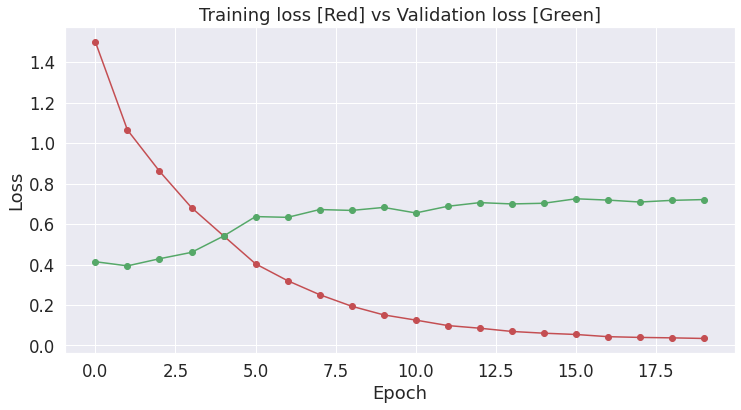

In [78]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'r-o')
plt.plot(eval_loss_values, 'g-o')

# Label the plot.
plt.title("Training loss [Red] vs Validation loss [Green]")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Saving Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [79]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


03/24/2020 09:51:15 - INFO - transformers.configuration_utils -   Configuration saved in ./model_save/config.json


Saving model to ./model_save/


03/24/2020 09:51:17 - INFO - transformers.modeling_utils -   Model weights saved in ./model_save/pytorch_model.bin


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

Let's check out the file sizes, out of curiosity.

In [80]:
!ls -l --block-size=K ./model_save/

total 428012K
-rw-r--r-- 1 root root      1K Mar 24 09:51 config.json
-rw-r--r-- 1 root root 427767K Mar 24 09:51 pytorch_model.bin
-rw-r--r-- 1 root root      1K Mar 24 09:51 special_tokens_map.json
-rw-r--r-- 1 root root      1K Mar 24 09:51 tokenizer_config.json
-rw-r--r-- 1 root root    227K Mar 24 09:51 vocab.txt


The largest file is the model weights, at around 418 megabytes.

In [81]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 418M Mar 24 09:51 ./model_save/pytorch_model.bin


To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [82]:
# Zip up the folder and copy zip file to Google Drive
!zip -r /content/modelBase_Multitask.zip /content/model_save/
!cp -r /content/modelBase_Multitask.zip "./drive/My Drive/Downloads"

  adding: content/model_save/ (stored 0%)
  adding: content/model_save/tokenizer_config.json (stored 0%)
  adding: content/model_save/config.json (deflated 56%)
  adding: content/model_save/special_tokens_map.json (deflated 40%)
  adding: content/model_save/vocab.txt (deflated 53%)
  adding: content/model_save/pytorch_model.bin (deflated 7%)


# Loading Saved Model

The following functions will load the model back from disk.  
First load the classification layers

In [0]:
import torch.nn as nn
from transformers.modeling_bert import BertPreTrainedModel, BertModel
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss

class BertForMultitask(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForMultitask, self).__init__(config)
        self.bert = BertModel(config)
        
        self.classifier = nn.Linear(config.hidden_size, out_features=11)
        self.s_classifier = nn.Linear(config.hidden_size, out_features=3)
        self.e_classifier = nn.Linear(config.hidden_size, out_features=4)

        # define dropout layer in __init__
        #self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.init_weights()

    def forward(self, input_ids=None, token_type_ids=None, attention_mask=None):
        _, pooled_output  = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        
        # apply model dropout to each classifier layer, responseive to eval()
        #pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # apply model dropout to each classifier layer, responseive to eval()
        #pooled_output = self.dropout(pooled_output)
        s_logits = self.s_classifier(pooled_output)

        # apply model dropout to each classifier layer, responseive to eval()
        #pooled_output = self.dropout(pooled_output)
        e_logits = self.e_classifier(pooled_output)
        
        outputs = logits, s_logits, e_logits
        return outputs


In [58]:
#output_dir = './drive/My Drive/EBAC_G/NLP_Project/Embeddings/model_Multitask/'
output_dir = '/content/model_save/'

# Load a trained model and vocabulary that you have fine-tuned
model = BertForMultitask.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

03/24/2020 08:46:00 - INFO - transformers.configuration_utils -   loading configuration file /content/model_save/config.json
03/24/2020 08:46:00 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForMultitask"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output

BertForMultitask(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

# Performance of Prediction

### Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [59]:
import spacy
import re
import os
import pandas as pd
from tqdm import tqdm

!python -m spacy download en_core_web_sm -q
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(nlp.create_pipe('sentencizer'))

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [60]:
file_path = "drive/My Drive/EBAC_G/NLP_Project/Embeddings/Western Union Co_20170502-Text.txt"
file_name = os.path.basename(file_path)
file_name = os.path.splitext(file_name)[0]

scripts = []
with open(file_path, 'r') as file:
  mydata = file.readlines()
  for lines in mydata:
    scripts.append(lines)

# get sentence segemented review with #sentences > 2
def sentence_segment_filter_docs(doc_array):
    sentences = []
    for doc in nlp.pipe(doc_array, disable=['parser', 'tagger', 'ner'], batch_size=1000, n_threads=8):
        sentences.append([sent.text.strip() for sent in doc.sents])

    return sentences


print(f'Found {len(scripts)} transcripts')
print(f'Tokenizing Transcripts...')

sentences = sentence_segment_filter_docs(scripts)
nr_sents = sum([len(s) for s in sentences])
print(f'Segmented {nr_sents} transcript sentences')


sentences = sentence_segment_filter_docs(scripts)

# Save to file
fn_out = f'corpus_{file_name}.txt'

with open(fn_out, "w") as f:
    for sents in tqdm(sentences):
        real_sents = []
        for s in sents:
            x = s.replace(' ', '').replace('\n', '')
            if x != '':
                real_sents.append(s.replace('\n', ''))
        # filter only paragraph more than or equal to 1 sentence        
        if len(real_sents) >= 1:
            str_to_write = "\n".join(real_sents) + "|||" + "\n"
            f.write(str_to_write)

print(f'Done writing to {fn_out}')


Found 205 transcripts
Tokenizing Transcripts...
Segmented 213 transcript sentences


100%|██████████| 205/205 [00:00<00:00, 68775.58it/s]

Done writing to corpus_Western Union Co_20170502-Text.txt


### Preprocessing the Test Dataset

In [61]:
import argparse
import collections
import logging
import json
import re
import math

import torch
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import BertModel

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

class InputExample(object):

    def __init__(self, unique_id, text_a, text_b):
        self.unique_id = unique_id
        self.text_a = text_a
        self.text_b = text_b

corpus = []
unique_id = 0
count = []
with open(fn_out, "r", encoding='utf-8') as input_file:
  for line in tqdm(input_file):
    line = line.strip()
    text_a = None
    text_b = None
    m = re.match(r"^(.*) \|\|\| (.*)$", line)
    if m is None:
      text_a = re.sub(r"(\|\|\|)$", "", line)
    else:
      text_a = m.group(1)
      text_b = m.group(2)
    corpus.append(InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b))
    unique_id += 1
    cnt = len(line.split())
    count.append(cnt)

MAX_LEN = int(math.ceil(max(count)/10)*10)
print(' ')
print('Max sentence length: ' + str(MAX_LEN))

# Set the maximum sequence length.
# In the original paper, the authors used a length of 512.
seq_length = MAX_LEN 
# type=int
# The maximum total input sequence length after WordPiece tokenization. 
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.

def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, unique_id, tokens, input_ids, input_mask, input_type_ids):
        self.unique_id = unique_id
        self.tokens = tokens
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.input_type_ids = input_type_ids

features = []
for (txt_index, sent_pair) in enumerate(corpus):
    tokens_a = tokenizer.tokenize(sent_pair.text_a)

    tokens_b = None
    if sent_pair.text_b:
        tokens_b = tokenizer.tokenize(sent_pair.text_b)

    if tokens_b:
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, seq_length - 3)
    else:
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > seq_length - 2:
            tokens_a = tokens_a[0:(seq_length - 2)]

    tokens = []
    input_type_ids = []
    tokens.append("[CLS]")
    input_type_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        input_type_ids.append(0)
    tokens.append("[SEP]")
    input_type_ids.append(0)

    if tokens_b:
        for token in tokens_b:
            tokens.append(token)
            input_type_ids.append(1)
        tokens.append("[SEP]")
        input_type_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < seq_length:
        input_ids.append(0)
        input_mask.append(0)
        input_type_ids.append(0)

    assert len(input_ids) == seq_length
    assert len(input_mask) == seq_length
    assert len(input_type_ids) == seq_length

    if txt_index < 5:
        logger.info("******")
        logger.info("unique_id: %s" % (sent_pair.unique_id))
        logger.info("tokens: %s" % " ".join([str(x) for x in tokens]))
        logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
        logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
        logger.info("input_type_ids: %s" % " ".join([str(x) for x in input_type_ids]))
    
        
    features.append(InputFeatures(
                unique_id=sent_pair.unique_id,
                tokens=tokens,
                input_ids=input_ids,
                input_mask=input_mask,
                input_type_ids=input_type_ids))
    

213it [00:00, 56954.40it/s]
03/24/2020 08:47:50 - INFO - __main__ -   ******
03/24/2020 08:47:50 - INFO - __main__ -   unique_id: 0
03/24/2020 08:47:50 - INFO - __main__ -   tokens: [CLS] thank you , hi ##km ##et [SEP]
03/24/2020 08:47:50 - INFO - __main__ -   input_ids: 101 4067 2017 1010 7632 22287 3388 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/24/2020 08:47:50 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/24/2020 08:47:50 - INFO - __main__ -   input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/24/2020 08:47:50 - INFO - __main__ -   ******
03/24/2020 08:47:50 - INFO - __main__ -   unique_id: 1
03/24/2020 08:47:50 - INFO - __main__ -   tokens: [CLS] first quarter reported revenues of $ 1 . 3 billion were flat or increased 3 % on a constant currency basis compared to the prior - ye

 
Max sentence length: 50


## Making Predictions


In [0]:
# For Prediction, we try higher batch size of 32

batch_size = 32
local_rank = -1 
#local_rank for distributed training on gpus

# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
unique_id_to_feature = {}
for feature in features:
    unique_id_to_feature[feature.unique_id] = feature

#if local_rank != -1:
    #model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[local_rank], output_device=local_rank)
#elif n_gpu > 1:
    #model = torch.nn.DataParallel(model)


# Convert to tensors, need "input_ids & its index", "input_mask" and "input_label"
# For testing set
prediction_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long) # Token ids for every sentences in individual list
prediction_input_ids_index = torch.arange(prediction_input_ids.size(0), dtype=torch.long) # Index for each sentences in one list
prediction_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)

prediction_data = TensorDataset(prediction_input_ids, prediction_input_mask, prediction_input_ids_index)

# Create the DataLoader for our testing set.
if local_rank == -1:
    prediction_sampler = SequentialSampler(prediction_data)
else:
    prediction_sampler = DistributedSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size) 
# No of item in dataloader = Total sample / Batch_size




With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [63]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = None

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_input_ids_index = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits, s_logits, e_logits = model(b_input_ids, token_type_ids=None, 
                                         attention_mask=b_input_mask)

      y_prob = logits.softmax(dim = -1) # normalizes values along axis 1
      s_y_prob = s_logits.softmax(dim = -1)
      e_y_prob = e_logits.softmax(dim = -1)

      if predictions is None:
        predictions = y_prob.detach().cpu().numpy()
        
        s_predictions = s_y_prob.detach().cpu().numpy()
        s_class = np.argmax(s_predictions, axis=1).flatten()
        
        e_predictions = e_y_prob.detach().cpu().numpy()
        e_class = np.argmax(e_predictions, axis=1).flatten()

      else:
        predictions = np.concatenate((predictions, y_prob.detach().cpu().numpy()), axis=0)

        s_predictions = np.concatenate((s_predictions, s_y_prob.detach().cpu().numpy()), axis=0)
        s_class = np.argmax(s_predictions, axis=1).flatten()
        
        e_predictions = np.concatenate((e_predictions, e_y_prob.detach().cpu().numpy()), axis=0)
        e_class = np.argmax(e_predictions, axis=1).flatten()
  
print('    DONE.')

Predicting labels for 213 test sentences...
    DONE.


For binary classification:  
y_prob = logits.sigmoid().cpu().numpy()   
prediction = np.argmax(y_prob, 1)   

For multi-label classification:  
y_prob = logits.softmax(-1).cpu().detach().numpy()  
prediction = np.argmax(y_prob, 1)  

In [64]:
predictions = np.round(predictions, decimals=3)
print("Sum of Aspect Mining Total Probability across " + str(len(predictions[0])) + " Aspects is " + str(sum(predictions[0])))

s_predictions = np.round(s_predictions, decimals=3)
print("Sum of Sentiment Classification Total Probability across " + str(len(s_predictions[0])) + " Sentiment is " + str(sum(s_predictions[0])))

e_predictions = np.round(e_predictions, decimals=3)
print("Sum of Emotion Classification Total Probability across " + str(len(e_predictions[0])) + " Emotion is " + str(sum(e_predictions[0])))


Sum of Aspect Mining Total Probability across 11 Aspects is 1.0000000069849193
Sum of Sentiment Classification Total Probability across 3 Sentiment is 0.9999999919673428
Sum of Emotion Classification Total Probability across 4 Emotion is 1.0000000015133992


In [65]:
# Extract the text used by the tokenizer
flat_txt = []
for (txt_index, sent_pair) in enumerate(corpus):
  txt = sent_pair.text_a
  flat_txt.append(txt)

# Concat the ids to the Sentiments and Emotion lables
s_txt = [str(s)+ "-" + Sid2label[int(s)] for s in np.nditer(s_class)]
e_txt = [str(e)+ "-" + Eid2label[int(e)] for e in np.nditer(e_class)]

# Concat the Predictions to a dataframe
text_df = pd.DataFrame(data=flat_txt, columns = ["text"])
s_class_df = pd.DataFrame(data=s_txt, columns = ["Sentiment"])
e_class_df = pd.DataFrame(data=e_txt, columns = ["Emotion"])

a_df = pd.DataFrame(data=predictions, columns = list(label2id))

s_df = pd.DataFrame(data=s_predictions, columns = list(Slabel2id))

e_df = pd.DataFrame(data=e_predictions, columns = list(Elabel2id))

output_df = pd.concat([text_df, s_class_df, e_class_df, a_df, s_df, e_df], axis=1)

# Saving to CSV
pred_name = f'predicted_{file_name}.csv'
output_df.to_csv(pred_name, index=True, header=True)

output_df.sample(3)

,text,Sentiment,Emotion,sales,earnings,op_costs,products_services,organic_expansion,acquisitions,competition,op_risks,debt,not_applicable,NIL,Negative,Neutral,Positive,Confident,Dodgy,NIL,Uncertain
209,That's something that we are extremely optimis...,2-Positive,0-Confident,0.632,0.098,0.020,0.139,0.040,0.010,0.006,0.006,0.004,0.010,0.034,0.002,0.045,0.953,0.956,0.001,0.031,0.012
79,The outstanding share count at quarter end was...,2-Positive,2-NIL,0.355,0.125,0.035,0.151,0.039,0.016,0.008,0.008,0.008,0.154,0.101,0.013,0.378,0.610,0.379,0.001,0.617,0.003
90,and State governments announced in January to ...,1-Neutral,2-NIL,0.089,0.073,0.042,0.098,0.025,0.014,0.009,0.009,0.010,0.477,0.154,0.022,0.958,0.021,0.045,0.003,0.941,0.011


In [0]:
# copy files to Google Drive
!zip -r /content/OutputBase_Multitask.zip /content/*.csv
!cp -r /content/OutputBase_Multitask.zip "./drive/My Drive/Downloads"

  adding: content/predicted_Western Union Co_20170502-Text.csv (deflated 71%)
